# Baseball Case 

## Data Exploration

We are given two datasets. The first dataset contains information about the 50 available players for the draft, and the second dataset contains information about 30 teams in the MLB. 

## Importing data and libraries

We will first import the necessary libraries and data, and determine which features (columns) are available in both team and player datasets. These features can be used to determine the best players to draft. 

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

player_df = pd.read_csv('player_data.csv')
hitting_df = pd.read_csv('hitting_data.csv')
pitching_df = pd.read_csv('pitching_data.csv')

player_df.set_index('Player #', inplace=True)
# convert column 'Player' to numeric, dropping commas 
player_df['Player'] = player_df['Player'].str.replace(',', '').astype(float)


pitching_df.set_index('TEAM', inplace=True)
# drop duplicate columns
pitching_df.drop('W', axis=1, inplace=True)
pitching_df.drop('L', axis=1, inplace=True)
pitching_df.drop('GP', axis=1, inplace=True)
pitching_df.drop('BB', axis=1, inplace=True)
pitching_df.drop('R', axis=1, inplace=True)
# pitching_df.rename(columns={'R':'R_pitching'}, inplace=True)


hitting_df.set_index('TEAM', inplace=True)
# hitting_df.rename(columns={'R':'R_hitting'}, inplace=True)

# merge hitting and pitching data
team_df = pd.merge(hitting_df, pitching_df, left_index=True, right_index=True)
team_df.drop('Team #', axis=1, inplace=True)

# determine which columns are present in both dataframes, these can be used as features
keep_cols = set(player_df.columns).intersection(set(team_df.columns))
keep_cols.add('TEAM')
keep_cols.add('R_hitting')
# keep_cols.add('R_pitching')


col_descriptions = {
    'GP' : 'Games Played',
    'AB' : 'At Bats',
    'R_hitting' : 'Runs Scored',
    'H' : 'Hits',
    '2B' : 'Doubles',
    '3B' : 'Triples',
    'HR' : 'Home Runs',
    'TB' : 'Total Bases',
    'RBI' : 'Runs Batted In',
    'BA' : 'Batting Average',
    'OBP' : 'On Base Percentage',
    'SLG' : 'Slugging Percentage',
    'OPS' : 'On Base Plus Slugging',
    'W' : 'Wins',
    'L' : 'Losses',
    'ERA' : 'Earned Run Average',
    'SV' : 'Saves',
    'CG' : 'Complete Games',
    'SHO' : 'Shutouts',
    'IP' : 'Innings Pitched',
    'QS' : 'Quality Starts',
    'ER' : 'Earned Runs',
    'R_pitching' : 'Runs Allowed',
    'BB' : 'Walks',
    'SO' : 'Strikeouts',
    'BAA' : 'Opponent Batting Average',
    'R' : 'Runs',
    'SB' : 'Stolen Bases',
    'CS' : 'Caught Stealing'}



#### Team Dataset

Given the target of "win more games next season", it is evident that the number of wins of each team is our target variable. 
We must determine which features are most important in predicting the number of wins of a team, and then use those features to identify which players to draft to most improve the performance of our team (team 26, Seattle). 


First, we will look at the distribution of the target variable, W (number of wins). 


count     30.000000
mean      80.933333
std       11.085664
min       59.000000
25%       74.000000
50%       83.000000
75%       89.000000
max      100.000000
Name: W, dtype: float64
Skewness: -0.256854
Kurtosis: -0.741269


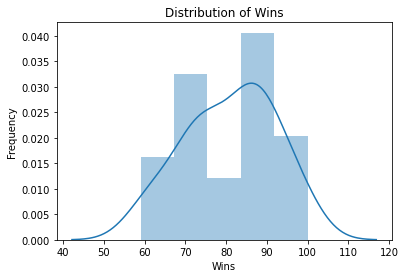

In [68]:
print(team_df['W'].describe())
# histogram
sns.distplot(team_df['W']);
# label the plot
plt.title('Distribution of Wins')
plt.xlabel('Wins')
plt.ylabel('Frequency')

print('Skewness: %f' % team_df['W'].skew())
print('Kurtosis: %f' % team_df['W'].kurt())


The number of wins is relatively normally distributed, with a mean of 80.933 and a standard deviation of 11.085. Our team has 61 wins which is significantly below the mean, which make sense since it is the 26th ranked team out of 30. 

Next, we will look at the relationship between the feature columns and the target variable. 

We can ignore columns that are not present in the player dataset, since those columns cannot be improved by drafting players, and any correlation between those and columns that are effective will be improved by drafting a player that improves the other feature column. 

We can also ignore W and L, since those are inherently directly correlated with the target variable.

Plotting the remainder of the columns, it is evident that some columns are much more correlated than others. 



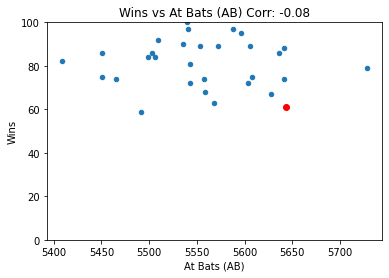

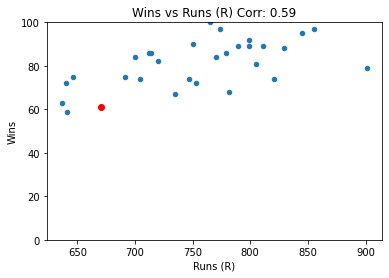

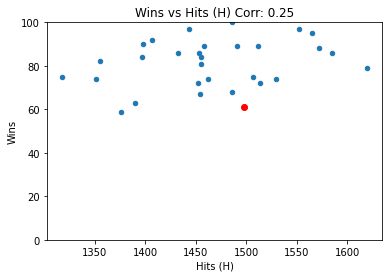

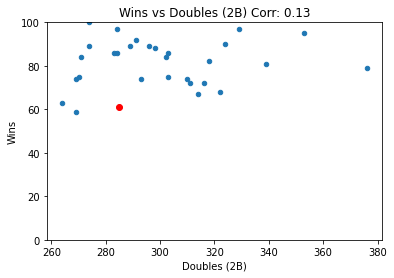

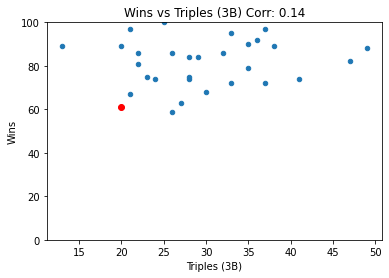

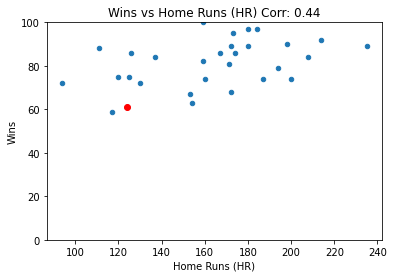

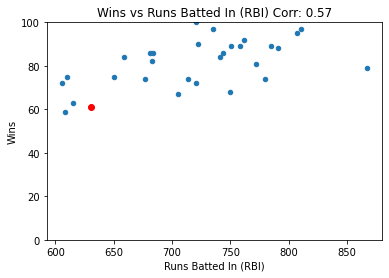

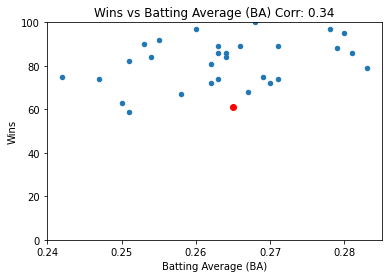

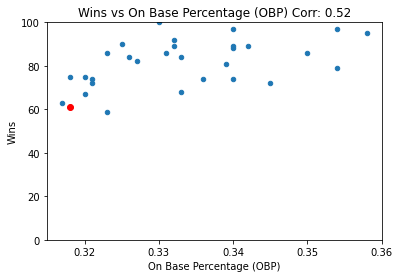

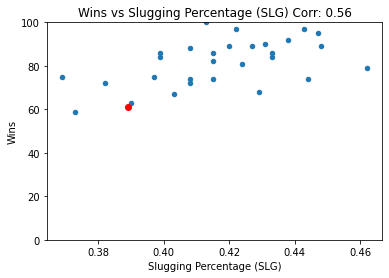

In [69]:
for i in team_df.columns:
    if i == 'W' or i == 'L' or i == 'GP' or i not in keep_cols:
        # print('Skipping: ', col_descriptions[i] + f' ({i})')
        continue
    data = pd.concat([team_df['W'], team_df[i]], axis=1)
    # highlight the data point associated with Seattle 
    data.plot.scatter(x=i, y='W', ylim=(0,100));
    plt.scatter(team_df.loc['Seattle'][i], team_df.loc['Seattle']['W'], color='red')
    # label the plot
    plt.title('Wins vs ' + col_descriptions[i] + f' ({i})' + ' Corr: ' + str(round(team_df['W'].corr(team_df[i]), 2)))
    plt.xlabel(col_descriptions[i] + f' ({i})')
    plt.ylabel('Wins')


In ranking our players, we will want to determine a correllation threshold between the features and the target variable. We will use a threshold of 0.25, which is subject to change. 

A threshold of 0.25 results in 8 features being selected: 
- R_hitting: Runs scored 
- HR: Home runs  
- RBI: Runs batted in 
- BA: Batting average
- OBP: On base percentage
- SLG: Slugging percentage
- R_pitching: Runs allowed
- BB: Walks 



Significant Columns (corr > 0.2):  ['R', 'H', 'HR', 'RBI', 'BA', 'OBP', 'SLG']


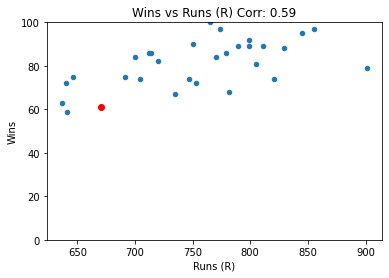

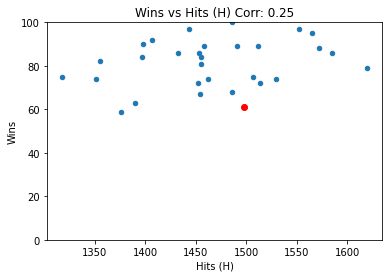

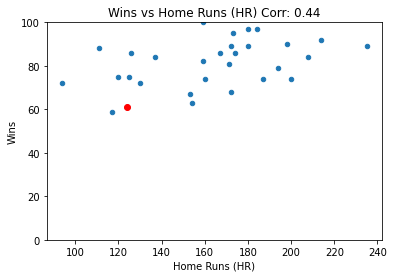

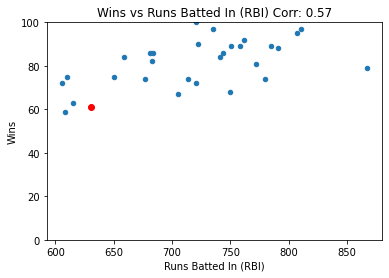

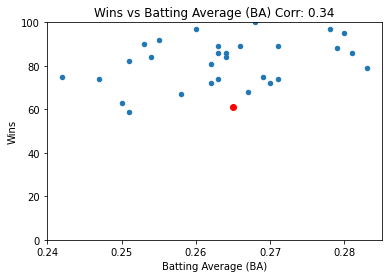

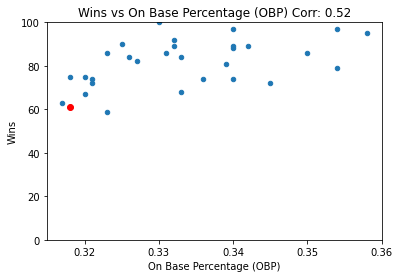

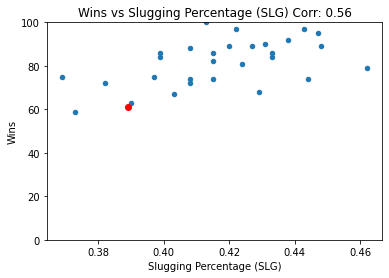

In [70]:
# eliminating variables with low correlation 
significant_cols = []
corr_tolerance = 0.2

for i in team_df.columns:
    correlation = team_df['W'].corr(team_df[i])
    if abs(correlation) < corr_tolerance or i == 'W' or i == 'L' or i == 'GP' or i not in keep_cols:
        # print('Skipping: ', col_descriptions[i] + f' ({i})')
        continue
    data = pd.concat([team_df['W'], team_df[i]], axis=1)
    # highlight the data point associated with Seattle 
    data.plot.scatter(x=i, y='W', ylim=(0,100));
    plt.scatter(team_df.loc['Seattle'][i], team_df.loc['Seattle']['W'], color='red')
    plt.title('Wins vs ' + col_descriptions[i] + f' ({i})' + ' Corr: ' + str(round(team_df['W'].corr(team_df[i]), 2)))
    plt.xlabel(col_descriptions[i] + f' ({i})')
    significant_cols.append(i)
    plt.ylabel('Wins')

print(f'Significant Columns (corr > {corr_tolerance}): ', significant_cols)

After selecting these 8 features, we will look at the correlation between each of these features. 

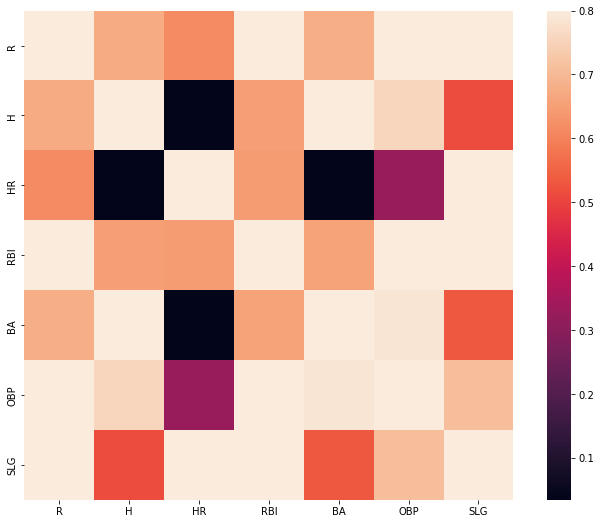

In [71]:
corrmat = team_df[significant_cols].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

We can see that there are some features that are highly correlated with each other.
This is not a problem, since we are not using these features to predict the target variable, but rather to identify which players to draft. 

#### Player Dataset

##### Exploring the data
The player dataset contains information about 50 players, and we will be using the 8 features selected in the previous section to determine which players to draft, along with the player's cost. 

We will first look at the correlation between the selected features. 


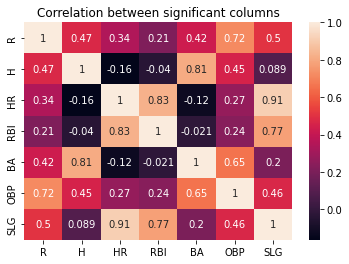

In [73]:
# plot the correlation between significant columns in the player_df
cols2 = significant_cols.copy()
# cols2.remove('R_hitting')
# cols2.append('R')

corr = player_df[cols2].corr()
sns.heatmap(corr, annot=True)
plt.title('Correlation between significant columns')
plt.show()

The selected features are somewhat correlated. This is not a problem, since we are not using these features to predict the target variable, but rather to identify which players to draft.

Next, we will look at the correlation between the selected features and the cost of the player.

Interestingly, the 'HR', 'RBI', and 'SLG' are not correlated at all with the cost of the player, even though the correlation between these features and the target variable is high. This suggests that we shouldn't weight the cost of the player too heavily when drafting players, rather we should primarily focus on improving the target metrics of our team while simply focusing on keeping the cost below budget. 


Text(0.5, 1.0, 'Correlation between significant columns and Player Cost')

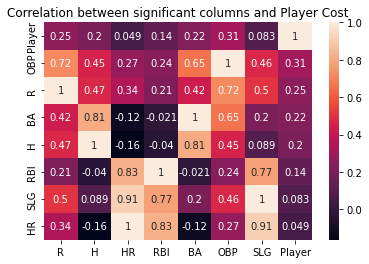

In [74]:
cols3 = cols2.copy()
cols3.append('Player')
corr = player_df[cols3].corr()
# sort the columns by correlation with Player Cost
corr = corr.sort_values(by='Player', ascending=False)
sns.heatmap(corr, annot=True)
plt.title('Correlation between significant columns and Player Cost')

### Drafting players

We chose to use several weights in ranking player data, in order of importance:
1. Correlation between features and number of wins in team dataset
2. Delta between our team's current features and the number 1 ranked team's features
3. Budget constraint

Our algorithm for choosing players works in the following manner:

1. Determine signifcant features based on correlation between team data and number of wins. (i.e. pick a correlation threshold, in this case 0.25). 
2. Get our team's current stats from the team dataframe. This will be updated as we draft players. 
3. Scale the player data between 0 and 1. This will be used to ensure that the weights of the features are not biased by metrics with larger values. 
4. Draft:
   1. Each draft round, a new delta value is calculated between our team's current stats and the number 1 ranked team's stats. This is a secondary weighting system beyond the correlation between features and number of wins.
   2. For each available player, a "player score" is calculated. This score is the sum of the product of the weights (correlation and team delta) and the player's scaled feature values. 
   3. The player's player score and budget score are added together to get the total score. The budget score has little impact on the total score unless a player is over budget, in which case the player is not considered.
5. The player's are ranked by their total score, and the player with the highest score is drafted. The current team stats are updated to reflect the drafted player's stats.




#### Determining Signifcant Features

In [75]:
def getSigCols(corr_tolerance: float, df: pd.DataFrame) -> list:
    # eliminating variables with low correlation 
    significant_cols = []
    for i in df.columns:
        correlation = df['W'].corr(df[i])
        if abs(correlation) < corr_tolerance or i == 'W' or i == 'L' or i == 'GP' or i not in keep_cols:
            # print('Skipping: ', col_descriptions[i] + f' ({i})')
            continue
        significant_cols.append((i,correlation))
    return significant_cols

#### Determining top players

In [189]:
def get_top_players(team, available_players, significant_cols, current_team, player_df, team_df, n=10, budget=30000000, picks_remaining=4):
    '''
    team: team name (string)
    available_players: list of player numbers that can still be drafted
    significant_cols: list of tuples of significant columns and their correlation with wins
    current_team: current team stats
    player_df: dataframe of player stats (scaled between 0 and 1)
    team_df: dataframe of team stats
    n: number of players to return
    budget: remaining budget
    picks_remaining: number of picks remaining
    '''
    cols = [i[0] for i in significant_cols]
    player_scores = {}
    ideal_stats = team_df.loc['LA Angels'] # use team with the most wins
    significant_cols_delta = {}

    ##########################################################################
    # Draft Step 4, Part 1: calculating delta
    delta_plot = [] 
    copy_cols = significant_cols.copy()
    original_weights = significant_cols.copy() # save the original column weights
    for i, (column, weight) in enumerate(copy_cols):
        current = current_team[column] # the current team's value for the given column
        ideal = ideal_stats[column] # the ideal stat value for the given column (based on the team with the most wins)
        diff = ideal - current 
        diff = max(0, diff) # no need to penalize a category if we exceed. 
        percentage_difference = diff / current # gives us the percentage difference from the current team's value 
        significant_cols_delta[column] = percentage_difference 
        adjusted_weight = weight # + (percentage_difference * weight) # dont adjust the weight for now
        delta_plot.append([percentage_difference, weight, adjusted_weight])
        significant_cols[i] = (significant_cols[i][0], adjusted_weight)
    
    delta_df = pd.DataFrame(delta_plot, columns=['Percentage Difference From Ideal', 'Original Weight', 'Adjusted Weight'])
    delta_df['sig_col'] = cols


    delta_df.index = delta_df['sig_col']
    delta_df = delta_df.drop(columns=['sig_col'])
    # delta_df = delta_df.sort_values(by='Percentage Difference From Ideal', ascending=False)
    # plot delta df barplot, color by weight
    delta_df.plot.bar()
    plt.title('Weight Makeup')
    plt.xlabel('Significant Column')
    plt.ylabel('Original Weight')
    plt.show()

    print('Significant Columns, adjusted weight: ', significant_cols)
    score_data = {}
    ##########################################################################
    # Draft Step 4, Part 2: calculating player scores
    player_plots = pd.DataFrame() 
    for player_number, player_row in player_df.iterrows():
        player_score = 0
        player_number += 1
        player_cost = player_row['Player Cost']
        col_makeup = [] # list of tuples of (column, weight)
        if player_number not in available_players or player_cost > budget:
            continue

        # calculate player score
        for col, weight in significant_cols:
            column_score = player_row[col] * weight
            player_score += column_score
            col_makeup.append([col, weight])
        # normalize the weights
        for i, (col, weight) in enumerate(col_makeup):
            col_makeup[i] = [col, weight/player_score] 

        ##### budget score #####
        # budget score is how close the player_cost is to the budget/picks_remaining
        target_budget = budget/picks_remaining
        budget_score = -(((player_cost - target_budget)/target_budget)**2)
        # col_makeup.append(['Budget Score', budget_score])
        budget_score = 0 # dont factor in budget score for now


        player_scores[player_number] = player_score + budget_score 
        col_makeup_df = pd.DataFrame(col_makeup, columns=['Column', 'Weight']) 
        col_makeup_df.index = col_makeup_df['Column']
        col_makeup_df = col_makeup_df.drop(columns=['Column'])
        player_plots[player_number] = col_makeup_df
    ##########################################################################
    # Draft Step 5: return the top n players
    # sort the player scores, and return the top n players
    sorted_player_scores = sorted(player_scores.items(), key=lambda x: x[1], reverse=True)
    sorted_df = pd.DataFrame(sorted_player_scores, columns=['Player', 'Score'])
    sorted_df.index = sorted_df['Player']
    sorted_df = sorted_df.drop(columns=['Player'])
    player_plots = player_plots.T

    # join player_plots with sorted_df, 
    merged = pd.merge(sorted_df, player_plots, left_index=True, right_index=True)

    # plot the makeup of player score for the top n players, aside from score
    merged2 = merged.drop(columns=['Score']) 
    merged2[:5].plot.bar()
    plt.title('Top 5 Player Score Makeup')
    plt.xlabel('Player')
    plt.ylabel('Weight')
    plt.show()

    merged2[5:10].plot.bar()
    plt.title('Rank 5-10 Player Score Makeup')
    plt.xlabel('Player')
    plt.ylabel('Weight')
    plt.show()

    merged['Our Rank'] = merged['Score'].rank(ascending=False)
    # make our rank the first column
    cols = merged.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    merged = merged[cols]

    merged['Player Cost'] = player_df['Player Cost']
    return sorted_player_scores[:n], merged 

#### Drafting Players

The below block generates our initial 10 picks. The othe file baseball_script.py will generate picks in a simulated draft environment. 

Significant Columns:  [('R', 0.5870160029097928), ('RBI', 0.567339912414405), ('SLG', 0.5580384983083135), ('OBP', 0.5205061170467745), ('HR', 0.44361584371171475), ('BA', 0.3370005999185718), ('H', 0.24682637643412042)]


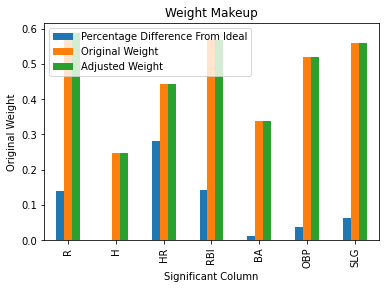

Significant Columns, adjusted weight:  [('R', 0.5870160029097928), ('H', 0.24682637643412042), ('HR', 0.44361584371171475), ('RBI', 0.567339912414405), ('BA', 0.3370005999185718), ('OBP', 0.5205061170467745), ('SLG', 0.5580384983083135)]


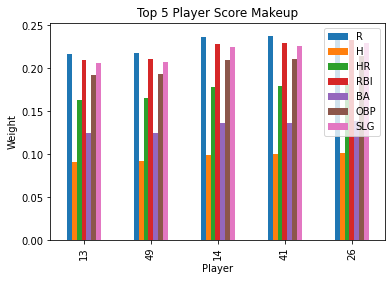

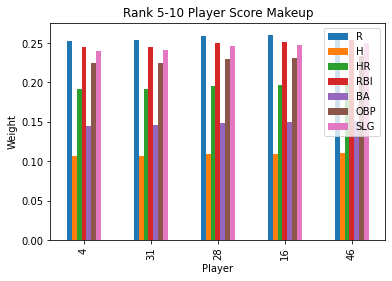

,Our Rank,Score,R,H,HR,RBI,BA,OBP,SLG,Player Cost
13,1.0,2.715599,0.216164,0.090892,0.163358,0.208919,0.124098,0.191673,0.205494,7750000.0
49,2.0,2.695121,0.217807,0.091583,0.164600,0.210506,0.125041,0.193129,0.207055,20625000.0
14,3.0,2.486390,0.236092,0.099271,0.178418,0.228178,0.135538,0.209342,0.224437,555000.0
41,4.0,2.477553,0.236934,0.099625,0.179054,0.228992,0.136022,0.210089,0.225238,5500000.0
26,5.0,2.437911,0.240786,0.101245,0.181966,0.232716,0.138233,0.213505,0.228900,11285714.0
4,6.0,2.321251,0.252888,0.106333,0.191111,0.244411,0.145181,0.224235,0.240404,1750000.0
31,7.0,2.314410,0.253635,0.106648,0.191676,0.245134,0.145610,0.224898,0.241115,8000000.0
28,8.0,2.269824,0.258617,0.108743,0.195441,0.249949,0.148470,0.229316,0.245851,19243683.0
16,9.0,2.256856,0.260103,0.109367,0.196564,0.251385,0.149323,0.230633,0.247264,11600000.0
46,10.0,2.233491,0.262824,0.110511,0.198620,0.254015,0.150885,0.233046,0.249850,7800000.0


In [190]:
available_players = list(player_df.index) 
# standardize the data, except for the Player column and index 
# scale between 0 and 1

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

normalized_player_df = player_df.drop('Player', axis=1)
normalized_player_df = scaler.fit_transform(normalized_player_df)
normalized_player_df = pd.DataFrame(normalized_player_df, columns=player_df.columns[1:])
normalized_player_df['Player Cost'] = player_df['Player']
normalized_player_df['Player ID'] = player_df.index

cur_team = team_df.loc['Seattle']

sigcols = getSigCols(0.2, team_df)
# print the significant columns, sorted by weight
print('Significant Columns: ', sorted(sigcols, key=lambda x: x[1], reverse=True))

# get the top 10 players for Seattle
seattle_players, df = get_top_players('Seattle', available_players, sigcols, cur_team, normalized_player_df, team_df=team_df) 

df.head(10)


## Validation of Drafting Algorithm

As a sanity check for our drafting algorithm, we ran it on the team dataset, and compared the results to the actual ranking of each team. The results are the following:

- Rank:  1 Texas Actual Rank:  1
- Rank:  2 Chicago Cubs Actual Rank:  2
- Rank:  3 Boston Actual Rank:  3
- Rank:  4 Chicago Sox Actual Rank:  6
- Rank:  5 Philadelphia Actual Rank:  9
- Rank:  6 Detroit Actual Rank:  5
- Rank:  7 St. Louis Actual Rank:  12
- Rank:  8 NY Yankees Actual Rank:  10
- Rank:  9 Cleveland Actual Rank:  7
- Rank:  10 NY Mets Actual Rank:  8
- Rank:  11 Tampa Bay Actual Rank:  13
- Rank:  12 Florida Actual Rank:  14
- Rank:  13 Milwaukee Actual Rank:  17
- Rank:  14 Minnesota Actual Rank:  4
- Rank:  15 Baltimore Actual Rank:  11
- Rank:  16 LA Angels Actual Rank:  15
- Rank:  17 Colorado Actual Rank:  18
- Rank:  18 Atlanta Actual Rank:  16
- Rank:  19 Arizona Actual Rank:  20
- Rank:  20 Houston Actual Rank:  22
- Rank:  21 Toronto Actual Rank:  21
- Rank:  22 Cincinnati Actual Rank:  23
- Rank:  23 LA Dodgers Actual Rank:  24
- Rank:  24 Pittsburgh Actual Rank:  19
- Rank:  25 Kansas City Actual Rank:  25
- Rank:  26 San Diego Actual Rank:  30
- Rank:  27 Seattle Actual Rank:  26
- Rank:  28 Oakland Actual Rank:  27
- Rank:  29 San Francisco Actual Rank:  29
- Rank:  30 Washington Actual Rank:  28



